In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def loadFile(fileName):
  with open(fileName, 'r') as f:
    filedata = f.read()
    return filedata

# Split data into packets
def parseData(file, transmitterIDs, angleOffset, timeOffset):
    splitFile = file[54:].split('\n\n')
    splitFile = splitFile[1:len(splitFile)-1]
    data = []
    for i in range(len(splitFile)):
      if(len(splitFile[i]) == 29) and splitFile[i][27:28] in transmitterIDs:
        dataPoint = []
        dataPoint.append(-int(splitFile[i][7:9])) # RSSI
        dataPoint.append(splitFile[i][27:28]) # ID
        dataPoint.append(int(int(splitFile[i][23:25] + splitFile[i][26:27], 16))) # Angle (need to normalise between 0 and 359 degrees)
        dataPoint.append(int(splitFile[i][14:16] + splitFile[i][17:19] + splitFile[i][20:22], 16)) # Relative time (not used in this notebook)
        data.append(dataPoint)

    # Standardize the angles
    maximum = max([x[2] for x in data])
    minimum = min([x[2] for x in data])
    for x in range(len(data)):
      data[x][2] = 359 *  ((data[x][2] - minimum) / (maximum-minimum))

    for x in range(len(data)):
      data[x][2] = np.deg2rad((data[x][2] + angleOffset) % (maximum+1))

    return data

def prepdata(filename):
    transmitterProfile = np.array(parseData(loadFile(filename), ['d','e','f'], 0, 0))
    data = transmitterProfile[transmitterProfile[:,1]=='d'][:,[0,2,3]].astype(float)
    data = data[np.argsort(data[:,-1]),:]
    return data

train_data = prepdata("no rf amp experiments/noamploc2long.log") #38
test_data = prepdata("no rf amp experiments/noamploc4.log") #150
#test_data = prepdata("no rf amp experiments/noamploc3.log") #180
#test_data = prepdata("no rf amp experiments/noamploc1.log") #250

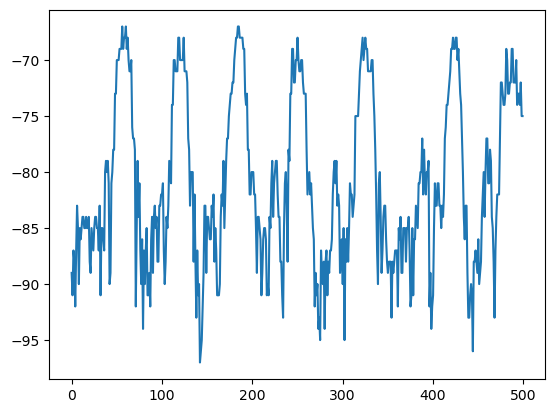

In [29]:
plt.plot(test_data[0:500,0])

In [50]:
def getsample(data,time):
    #times = np.array([time-300,time-100,time+100,time+300,time])
    times = np.array([time-400,time-200,time+200,time+400,time])
    idxs = np.argmin(np.abs(data[:,-1:]-times[None,:]),0)
    sigs = data[idxs,0]
    signaldiffs = sigs[:-1]-sigs[-1]
    
    #signaldiffs = np.array([data[idxs[0],0]-data[idxs[1],0],data[idxs[2],0]-data[idxs[1],0]])
    #return signaldiffs,np.mean(data[idxs,1]),data[idxs,0]
    return signaldiffs,data[idxs[-1],1],data[idxs,0]

def build_training_record(data):
    record = []
    mint,maxt = np.min(data[:,-1]),np.max(data[:,-1])
    #avgss = [1000]*20
    for i,t in enumerate(np.arange(mint+100e3,maxt,50)):
        #del avgss[:3]
        #avgss.extend(list(rawss))
        signalstrengths,angle,rawss = getsample(data,t)
        #if np.mean(rawss)<np.mean(avgss)+3: continue ### IS IT A GOOD IDEA TO REMOVE FROM THE TRAINING SIGNALS THAT <3dB ABOVE AVG??!?
        record.append([t]+list(signalstrengths)+[angle])
        #print(angle)
        if i%1000==0:
            print(t-mint,maxt-mint)
    return np.array(record)

record = build_training_record(train_data)

100000.0 733482.0
150000.0 733482.0
200000.0 733482.0
250000.0 733482.0
300000.0 733482.0
350000.0 733482.0
400000.0 733482.0
450000.0 733482.0
500000.0 733482.0
550000.0 733482.0
600000.0 733482.0
650000.0 733482.0
700000.0 733482.0


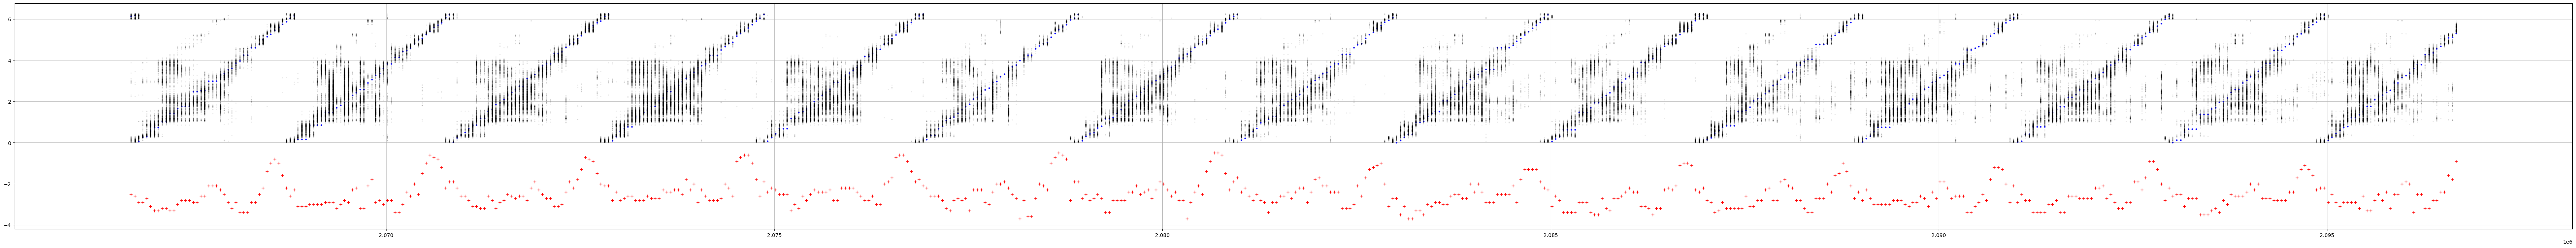

In [56]:
plt.figure(figsize=[90,8])
def compute_predictions(data,record):
    mint,maxt = np.min(data[:,-1]),np.max(data[:,-1])
    predictions = []
    avgss = [1000]*20
    for i,t in enumerate(np.arange(mint+70e3,mint+100e3,50)):    
        ss,ang,rawss = getsample(data,t)
        ang-=np.deg2rad(38+150)#250)
        ang=ang%(2*np.pi)
        del avgss[:1]
        #avgss.extend(list(rawss))
        avgss.append(rawss[-1])

        select = np.all(np.abs(ss-record[:,1:-1])<6,1) #all 5 measurements must be <6 dB out
        #select = np.sum(np.abs(ss-record[:,1:-1]),1)<10 #sum of errors <10dB
        predangle = record[select,-1]    

        plt.plot(t,ang,'.b',markersize=4)
        
        plt.plot(t,(rawss[-1]+60)/10,'r+')

        ####if np.mean(rawss[-1])<np.mean(avgss)+4: continue
        #if len(predangle)<10: continue

        #if (np.std(predangle)>0.04): continue
        ####if len(predangle)<5: continue
        ####if (np.std(predangle)>0.1): continue
        plt.plot(np.repeat(t,len(predangle)),predangle,'.k',markersize=3,alpha=0.05)
        
        predictions.append([ang,predangle])
    return predictions
   
predictions = compute_predictions(test_data,record)
plt.grid()
#plt.savefig('a.pdf')

In [57]:
summary = np.array([[trueang, np.mean(preds)] for trueang, preds in predictions])

/home/mike/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mike/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


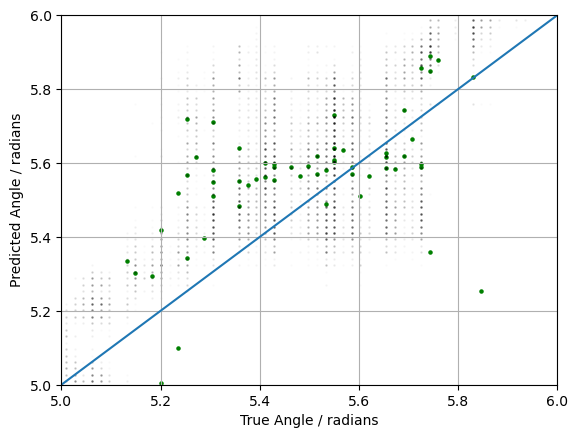

In [58]:
plt.scatter(summary[:,0],summary[:,1],5,color='green')
for trueang, preds in predictions:
    plt.scatter(np.repeat(trueang,len(preds)),preds,1,color='black',alpha=0.01)
plt.plot([0,np.pi*2],[0,np.pi*2])
plt.xlim([5,6])
plt.ylim([5,6])
#plt.plot([0,2*np.pi],[0,2*np.pi])
plt.xlabel('True Angle / radians')
plt.ylabel('Predicted Angle / radians')
plt.grid()

In [54]:
np.rad2deg(np.mean(np.abs(summary[:,1]-summary[:,0]))) #MAE is 1.78 degrees!

11.59459459459461